In [10]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

rcParams['figure.figsize'] = (13, 6)

f:\Anaconda\envs\nilmtk-env\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


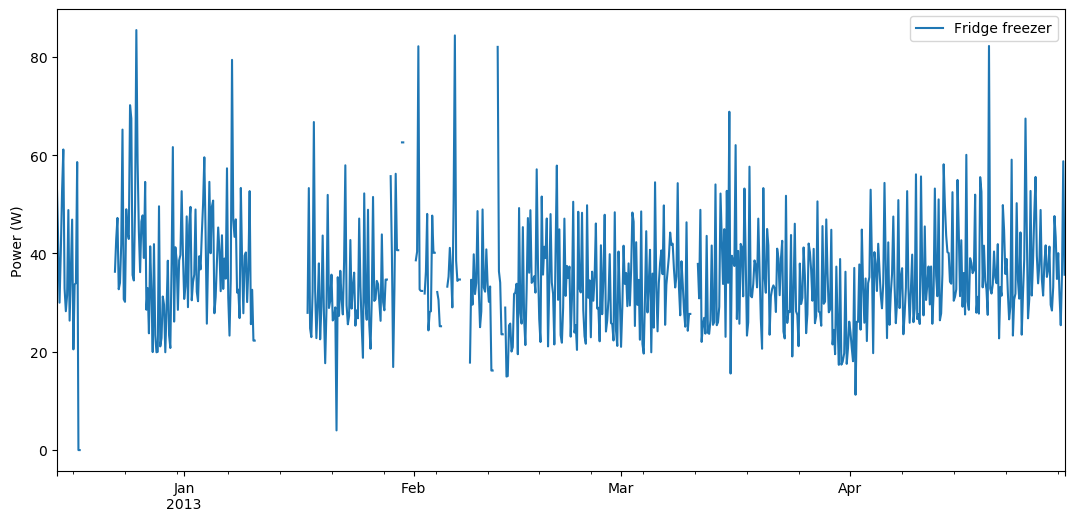

In [12]:
train = DataSet(r'E:\重庆师范大学\研一上\非侵入式负荷检测\program\data\ukdale_h5\ukdale.h5')
test = DataSet(r'E:\重庆师范大学\研一上\非侵入式负荷检测\program\data\ukdale_h5\ukdale.h5')

building = 1

train.set_window(end="2013-04-30")
test.set_window(start="2013-04-30")

train_elec = train.buildings[1].elec   
test_elec = test.buildings[1].elec

# train_elec.plot() #画不出来，太大了，只画冰箱的
train_elec['fridge'].plot()

f:\Anaconda\envs\nilmtk-env\lib\site-packages\nilmtk\utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")


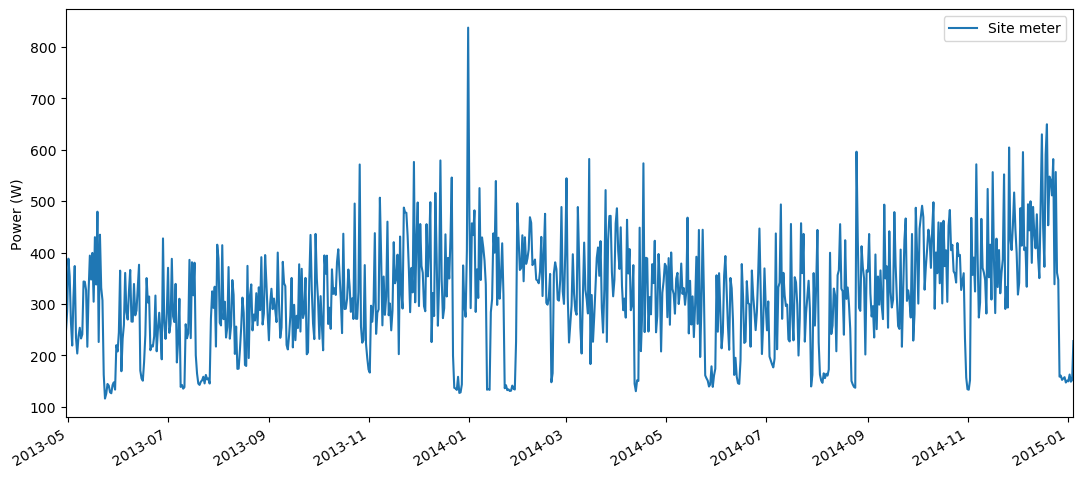

In [3]:
test_elec.mains().plot()    #site_meter测量的aggregation

In [4]:
fridge_meter = train_elec['fridge']
fridge_df = next(fridge_meter.load())
fridge_df.head()

physical_quantity,power
type,active
2012-12-14 22:21:32+00:00,85.0
2012-12-14 22:21:38+00:00,85.0
2012-12-14 22:21:44+00:00,84.0
2012-12-14 22:21:50+00:00,85.0
2012-12-14 22:21:56+00:00,85.0


In [5]:
mains = train_elec.mains()
mains_df = next(mains.load())   #Done loading data all meters for this chunk.

mains_df.head()

physical_quantity,power,voltage,power
type,active,,apparent
2013-03-17 19:12:43.100000+00:00,337.880005,240.149994,431.040009
2013-03-17 19:12:44.100000+00:00,339.429993,240.559998,427.940002
2013-03-17 19:12:45.100000+00:00,340.630005,241.070007,429.660004
2013-03-17 19:12:46.100000+00:00,338.799988,240.440002,426.989990
2013-03-17 19:12:47.100000+00:00,340.880005,241.009995,429.130005


In [18]:
# Selecting top-5 appliances
top_5_train_elec = train.buildings[1].elec.select_using_appliances(type = 'fridge')   # Only select the top K meters, according to energy.
test_elec = test.buildings[1].elec

Training and disaggregation

A function to disaggregate the mains data to constituent appliances and return the predictions

# 以下代码跑不起来，有时候报索引错误（索引减半），有时候报内存错误

In [22]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power',ac_type = 'best', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()  #Remove missing values.
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power',ac_type = 'best', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

Train using 2 benchmarking algorithms - Combinatorial Optimisation (CO) and Factorial Hidden Markov Model (FHMM)

In [ ]:
classifiers = {'CO':CombinatorialOptimisation()}
predictions = {}
sample_period = 120
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(top_5_train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

In [ ]:
appliance_labels = [m.label() for m in gt.columns.values]

gt.columns = appliance_labels
predictions['CO'].columns = appliance_labels
#predictions['FHMM'].columns = appliance_labels

gt.head()

In [ ]:
predictions['CO'].head()

In [ ]:
predictions['FHMM'].head()

Plotting the predictions against the actual usage

In [ ]:
predictions['CO']['Fridge'].head(300).plot(label="Pred")
gt['Fridge'].head(300).plot(label="GT")
plt.legend()

Comparing NILM algorithms (CO vs FHMM)

In [ ]:
def compute_rmse(gt, pred):
    from sklearn.metrics import mean_squared_error
    rms_error = {}
    for appliance in gt.columns:
        rms_error[appliance] = np.sqrt(mean_squared_error(gt[appliance], pred[appliance]))
    return pd.Series(rms_error)

In [ ]:
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = nilmtk.utils.compute_rmse(gt, predictions[clf_name])

rmse = pd.DataFrame(rmse)
rmse